<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Notebook-Snapshots/RuntypeBERT/5.2.2%20distilBERT2SVM_4SA-NepCov19TweetsPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00


In [8]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

bertModel = 'raygx/sakoni-distilBERT-NepSA' ## 'raygx/distilBERT-NepSA' ## Fine-tuned Model for SA
bertTokenizer = PreTrainedTokenizerFast.from_pretrained(bertModel, model_input_names=['input_ids','attention_mask'])
try:
    bertModel = TFAutoModel.from_pretrained(bertModel)#,revision='3d8fa5f1a60104bad4592461a0237b85b9c8756c')
except:
    bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

bertModel.config

Some layers from the model checkpoint at raygx/sakoni-distilBERT-NepSA were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at raygx/sakoni-distilBERT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


DistilBertConfig {
  "_name_or_path": "raygx/sakoni-distilBERT-NepSA",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.32.0",
  "vocab_size": 24581
}

In [9]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [10]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [11]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [12]:
import tensorflow as tf

class dBERTEmbedding(tf.keras.layers.Layer):
    def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
        super().__init__()
        self.embedding = model
        self.tokenizer = tokenizer
        self.max_token = max_token_len
        self.padding = padding
        self.truncation = truncation
        self.trainable=False

    def call(self, x):
        x = self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))
        return x['last_hidden_state'][:,0,:]

### Preparing Training Data

In [13]:
from tqdm.auto import tqdm

bertEmbd = dBERTEmbedding(model=bertModel,tokenizer=bertTokenizer,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat1 = bertEmbd(data['train'][i:i+batch]['text'])

    ## Using BERT Feature Only
    feat = feat1 #tf.concat((feat1,feat2),1)
    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 768)

In [14]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [15]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 4min 42s, sys: 485 ms, total: 4min 43s
Wall time: 4min 44s


array([0, 1, 2])

### Preparing Test Data

In [16]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat1 = bertEmbd(data['test'][i:i+batch]['text'])

    ## Using BERT Feature Only
    feat = feat1 #tf.concat([feat1,feat2],1)
    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

testX.shape

  0%|          | 0/260 [00:00<?, ?it/s]

(8309, 768)

## Evaluation

In [17]:
%%time
predictions = clf.predict(testX)

CPU times: user 1min 20s, sys: 114 ms, total: 1min 20s
Wall time: 1min 20s


In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.8497332520424289
Precision-Score 0.85259661227321
Recall-Score 0.8496810687206643
accuracy_Score 0.8496810687206643


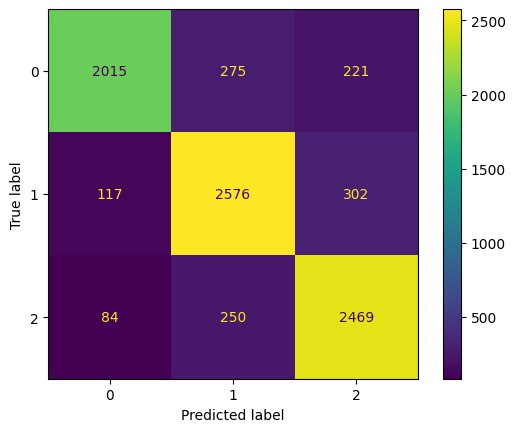

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()

